# Example Notebook For Group Projects#

08-20-2015

This is an example notebook for the types of analysis that will be performed on Day 5 of the Biocomputing Bootcamp.

Students will perform the following tasks:
1. Obtain Data
2. Format Data
3. Parse Data
4. Associate Data
5. Visualize Data

###Setup

In [5]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import subprocess
import re
from pylab import plot,show
from scipy import stats
import os
import csv
import vcf
import sys
import pysam
from operator import itemgetter
from itertools import groupby, cycle

workDir = '/scratch/remills_flux/remills/day5'
genoDir= '/scratch/biobootcamp_fluxod/remills/bioboot/geuvadis/genotypes'
expDir = '/scratch/biobootcamp_fluxod/remills/bioboot/geuvadis/analysis_results'

os.chdir(workDir)

print 'Work directory is',os.getcwd()
print 'Genotype directory is',genoDir
print 'Gene Expression directory is',expDir

Work directory is /scratch/remills_flux/remills/day5
Genotype directory is /scratch/biobootcamp_fluxod/remills/bioboot/geuvadis/genotypes
Gene Expression directory is /scratch/biobootcamp_fluxod/remills/bioboot/geuvadis/analysis_results


###Obtaining Data
Scientists must often make use of large data sets that are made available on either websites or data repositories. Here, we have already downloaded the pertinent data, but for reference here is a way the data could be obtained.

In [6]:
#os.chdir(expDir)
#subprocess.call(["wget", "ftp://ftp.ebi.ac.uk/pub/databases/microarray/data/experiment/GEUV/E-GEUV-1/analysis_results/*"])
#os.chdir(genoDir)
#subprocess.call(["wget", "ftp://ftp.ebi.ac.uk/pub/databases/microarray/data/experiment/GEUV/E-GEUV-1/genotypes/*"])
#os.chdir(workDir)

### Format Data
The next step is to pull out the region of interest from these data. For each file, we will make use of *indexing* that provides random access to the files. In particular, we will use *tabix* which allows for coordinate based indexing of tab-delimited files, but this too requires additional processing as files must be first sorted and then recompressed using an index-supporting compression algorithm (*bgzip*). This has already been done but is shown for completeness.

In [7]:
#Expression Directory

#Need to sanitize, sort, and index expression file
#os.chdir(expDir)

#unzip file for use
#subprocess.call(["gunzip", "GD660.GeneQuantRPKM.txt.gz"])

#read in file and store header in data structure
expHeader = [];
samples = [];

o = open(expDir+'/GD660.GeneQuantRPKM.txt', 'r')
#w = open('GD660.GeneQuantRPKM.header', 'w')
for line in o:
    rlist = re.split(r'\t+', line.rstrip())
    out = ""
    i=0;
    for e in rlist:
        i = i+1
        col = re.split(r'\.', e)
        expHeader.append(col[0])
        if i>=5:
            samples.append(col[0])
    break #only want first line
#w.write('\t'.join(expHeader)+'\n')
#w.close()
o.close()


#subprocess.call("(cat GD660.GeneQuantRPKM.header && tail -n +2 GD660.GeneQuantRPKM.txt | sort -k3,3 -k4,4n) > GD660.GeneQuantRPKM_sorted.txt", shell=True)
#subprocess.call(["bgzip", "GD660.GeneQuantRPKM_sorted.txt"])
#subprocess.call(["gzip", "GD660.GeneQuantRPKM.txt"]) #recompress original file
#subprocess.call(["tabix", "-s", "3", "-b", "4", "-e", "4", "-f", "GD660.GeneQuantRPKM_sorted.txt.gz"])
#os.chdir(workDir)

#Genotype Directory
#os.chdir(genoDir)
#files = os.listdir(genoDir)
#Compression intensive on large files, would be better as a standalone process
#for file in files:
#    if re.search(r'vcf.gz',file):
#        subprocess.call(["gunzip", file])
#        file = re.sub(r'vcf.gz',r'vcf', file)
#        subprocess.call(["bgzip", file])
#        file = re.sub(r'.vcf',r'.vcf.gz',file)
#        subprocess.call(["tabix", file, "-p", "vcf"])

###Regions
chr5:95,984,676-96,185,176 - Alcohol Dependence - ERAP1 - rs13160562 GWAS, rs1057569 eQTL  
chr11:47,426,802-47,627,302 - Body Mass Index - MTCH2 - rs3817334 GWAS, rs10838724 eQTL  
chr1:205,620,478-205,820,978 - Parkinsons disease - RAB7L1 - rs947211 GWAS, rs708725 eQTL  
chr21:38,432,812-38,633,312 - Eye color traits - TTC3 - rs1003719 GWAS, rs3787788 eQTL  
chr20:5,883,504-6,084,004 - HIV-1 control - MCM8 - rs454422 GWAS, rs13041190 eQTL  
chr5:156,807,522-157,008,022 - Pulmonary function - ADAM19 - rs2277027 GWAS, rs9313615 eQTL  

### Parse Data
Now that we have the files in the proper format, we will pull out the relevant portions to our analysis using one of the regions of interest. Given that each region is ~200,000 bp in size, there will likely be many more SNPs than there are genes in the region. Therefore, it makes sense to first read in the gene expression data and store it first, and then do the genotype comparisons in a stepwise fashion.



Gene: ENSG00000249180.1
Best Snp: snp_5_96170765
P-value: 1.31159253106e-05


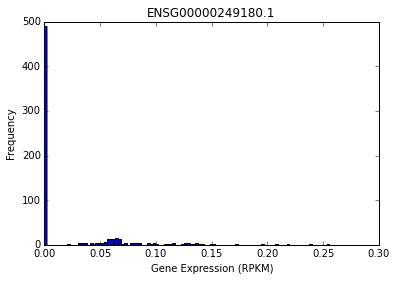

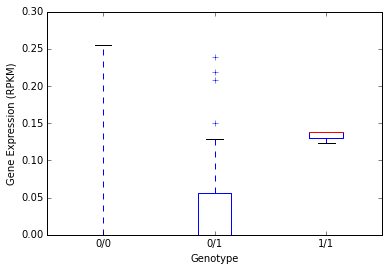

Gene: ENSG00000248734.1
Best Snp: snp_5_96114550
P-value: 2.96591056658e-17


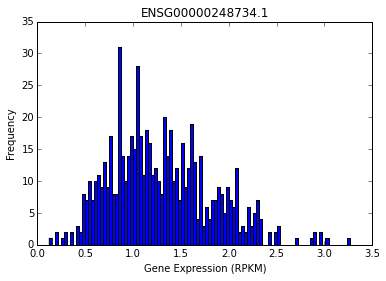

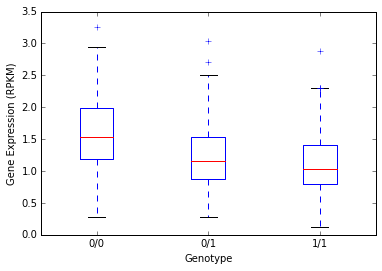

Gene: ENSG00000164307.7
Best Snp: snp_5_96124959
P-value: 1.03841478464e-66


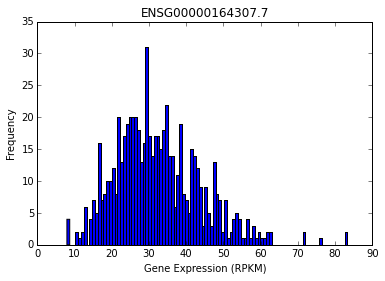

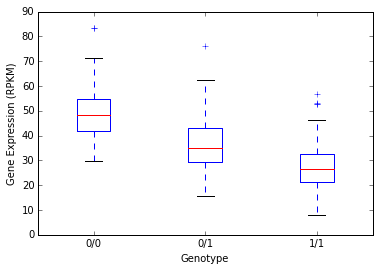

In [11]:
#region information goes here
chromo = "5"
startPos = 95984676
endPos = 96185176

#startPos = 95584676
#endPos = 96585176

#chromo = "11"
#startPos = 47426802
#endPos = 47627302

#chromo = "1"
#startPos = 205620478
#endPos = 205820978

region = chromo + ":" + str(startPos) + "-" + str(endPos) #format for tabix
regionLabel = chromo + "_" + str(startPos) + "_" + str(endPos) #format for files
regionFile = workDir + "/" + regionLabel+ ".vcf"
genoFile = genoDir + '/GEUVADIS.chr' + chromo + '.PH1PH2_465.IMPFRQFILT_BIALLELIC_PH.annotv2.genotypes.vcf.gz'

#need to fix VCF file for parser
f = open(workDir + "/" + regionLabel+".vcf", "w")
subprocess.call(["tabix", "-h", genoFile, region], stdout = f)
f.close()
subprocess.call(["sed", "-i", "s/POLYPHEN.*;[A-Z]//g", regionFile])
subprocess.call(["bgzip", regionFile])
subprocess.call(["tabix", "-f", "-p", "vcf", regionFile + ".gz"])


genoFile = regionFile + ".gz"
expFile = expDir + "/GD660.GeneQuantRPKM_sorted.txt.gz"

plot = 0 #set to generate plots
data = {} #initialize dict for storing data

#f = open(workDir+"/regionExp.txt","wb") #open file to redirect stdout

proc = subprocess.Popen(['tabix', expFile, region], stdout=subprocess.PIPE)
while True:
    line = proc.stdout.readline()

    if line == '':
        break;
    else:
        #split line into a list
        geneList = re.split(r'\t+', line.rstrip())
        #combine list with previously generated header to create a dictionary
        expDict = dict(zip(expHeader, geneList)) 
        data[expDict['Gene_Symbol']] = []
        
         
        bestExpCol = []
        bestGenoCol = []
        bestPval = 1e10
        bestSnp = ""
        bestGene = ""
        
        #Now read in VCF file using PyVCF to compare against list
        vcf_reader = vcf.Reader(filename=genoFile)
        for record in vcf_reader.fetch(chromo, startPos, endPos):
            #only consider MAF > 5%
            if record.INFO['AF'] < 0.05 or record.INFO['AF'] > 0.95:
                    continue
            
            #look up each sample genotype using sample list

            expCol = []
            genoCol = []
            
            for sample in samples:
                call=record.genotype(sample)
                geno = call.gt_type
                if geno != 0 and geno != 1 and geno != 2:
                    geno = 0;
                expCol.append(float(expDict[sample]))
                genoCol.append(int(geno))
                
            #conver to numpy array for calculations     
            y = np.array(expCol)
            xi = np.array(genoCol)
            
            #Based on http://glowingpython.blogspot.com/2012/03/linear-regression-with-numpy.html
            slope, intercept, r_value, p_value, std_err = stats.linregress(xi,y)
            data[expDict['Gene_Symbol']].append([record.CHROM, record.POS, p_value])
            
            if p_value < bestPval:
                bestExpCol = expCol
                bestGenoCol = genoCol
                bestPval = p_value
                bestSnp = record.ID
                bestGene = expDict['Gene_Symbol']
                
            #plot quick scatter plot with regression line
            if p_value < 1e-50 and plot:
                print record.ID
                print expDict['Gene_Symbol']
                print 'r value', r_value
                print  'p_value', p_value
                print 'standard deviation', std_err

                line = slope*xi+intercept
                plt.plot(xi,line,'r-',xi,y,'o')
                plt.show()
        
        print "Gene:", expDict['Gene_Symbol']
        print "Best Snp:", bestSnp
        print "P-value:", bestPval
        
        plt.hist(bestExpCol, bins=100)
        plt.title(expDict['Gene_Symbol'])
        plt.xlabel("Gene Expression (RPKM)")
        plt.ylabel("Frequency")
        plt.show()
        
        geno_0 = []
        geno_1 = []
        geno_2 = []
        for idx, val in enumerate(bestGenoCol):
            if val == 0:
                geno_0.append(bestExpCol[idx])
            elif val == 1:
                geno_1.append(bestExpCol[idx])
            elif val == 2:
                geno_2.append(bestExpCol[idx])
        
        fig = plt.figure()
        ax = fig.add_subplot(111)   
        ax.boxplot([geno_0, geno_1, geno_2], labels=["0/0", "0/1", "1/1"])
        ax.set_xlabel('Genotype')
        ax.set_ylabel('Gene Expression (RPKM)')
        plt.show()
        

###Visualization
Use existing code to generate a Manhattan plot of the derived P-values

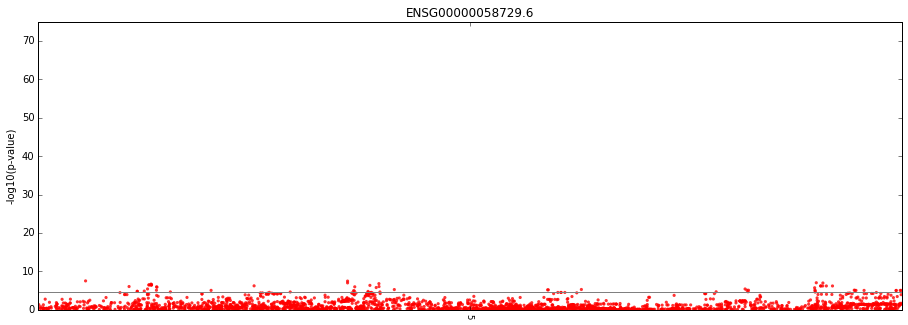

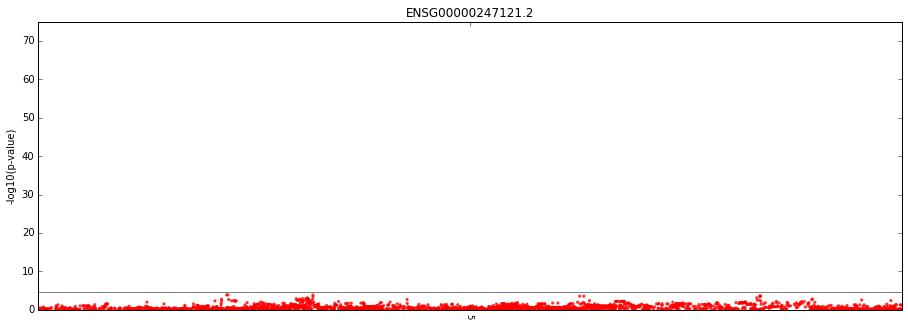

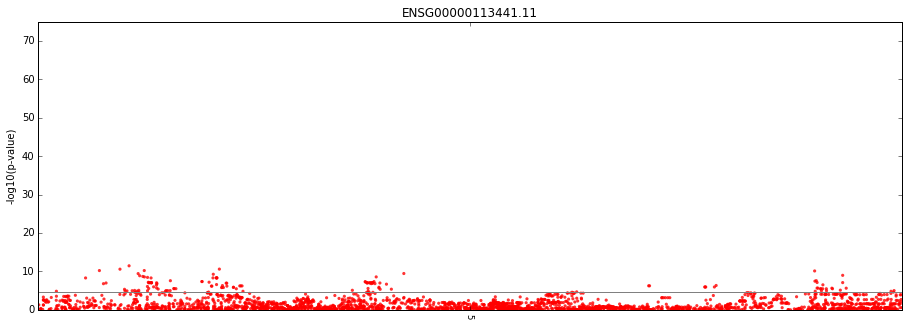

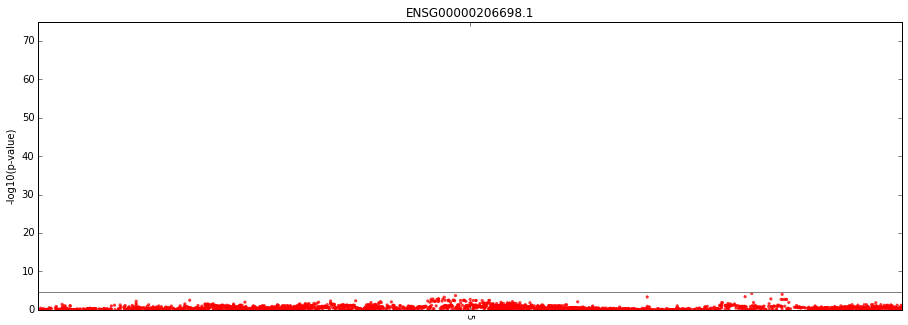

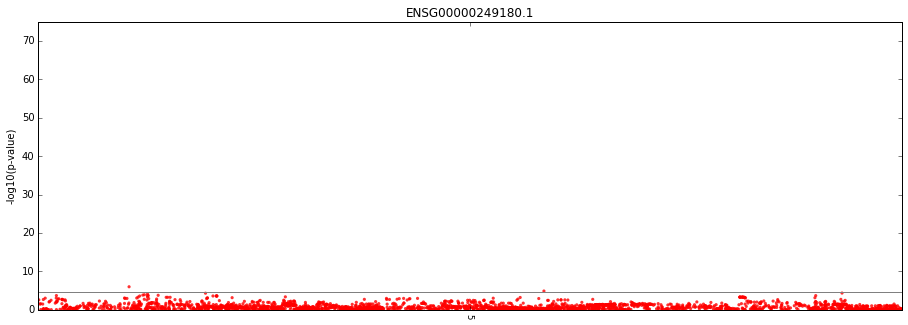

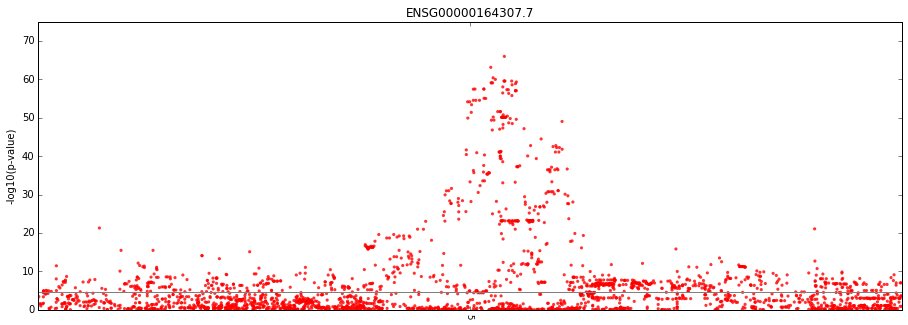

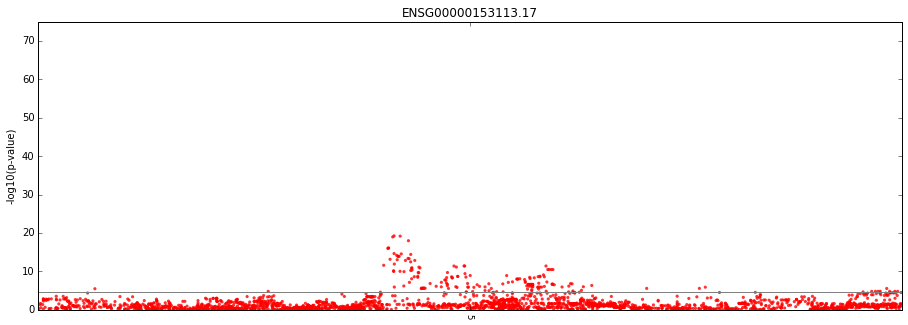

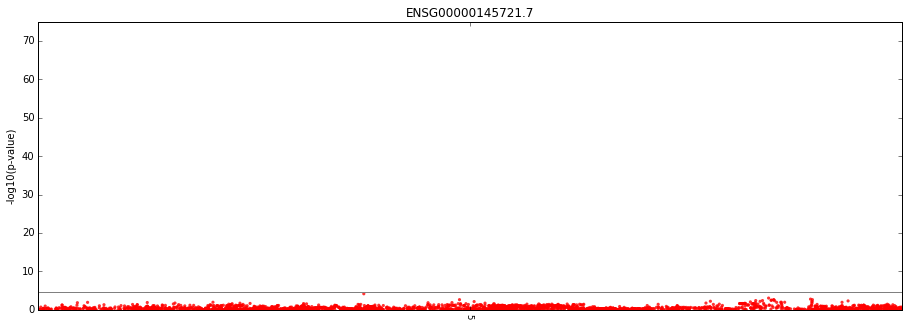

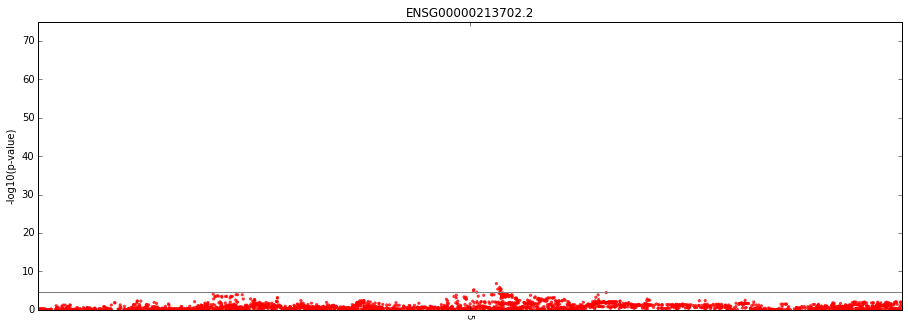

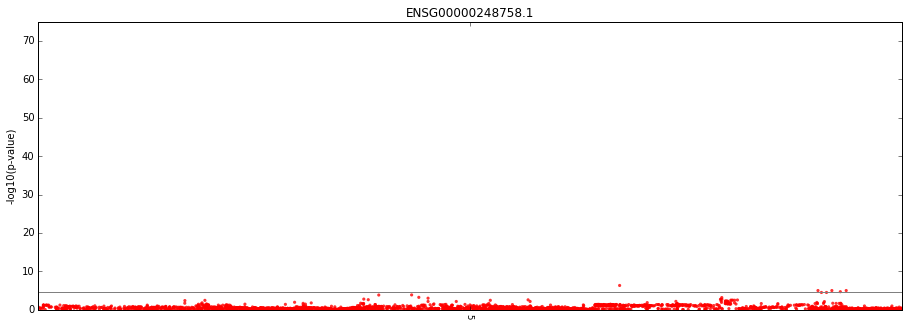

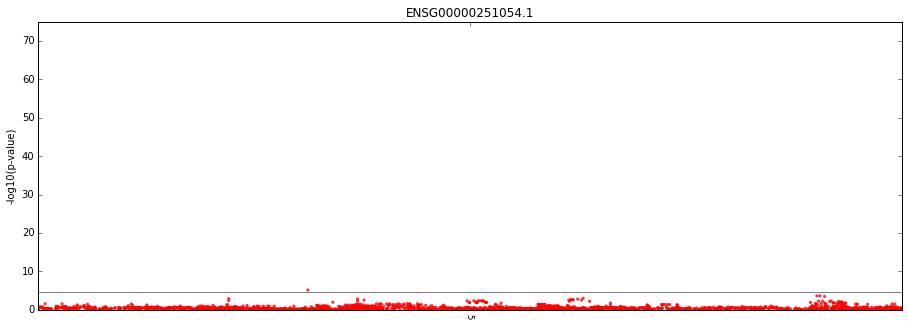

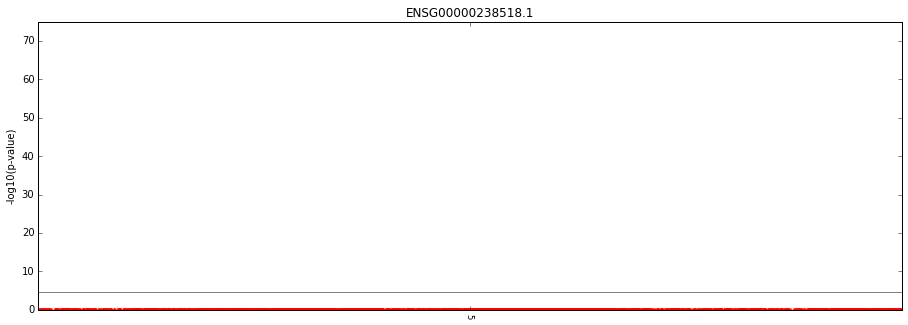

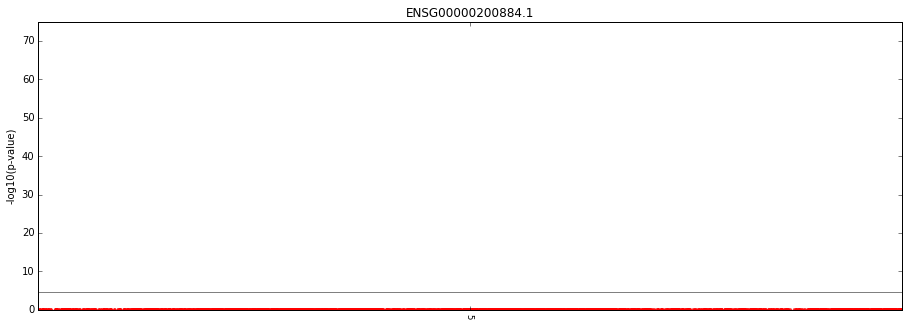

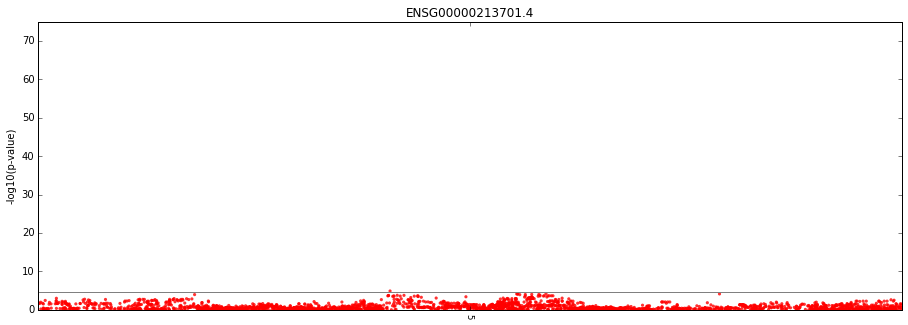

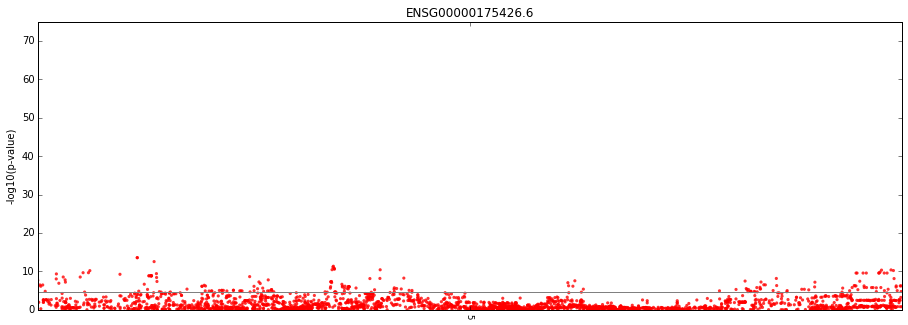

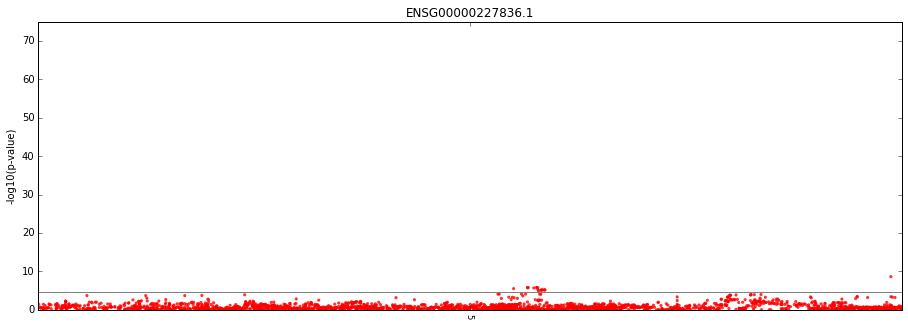

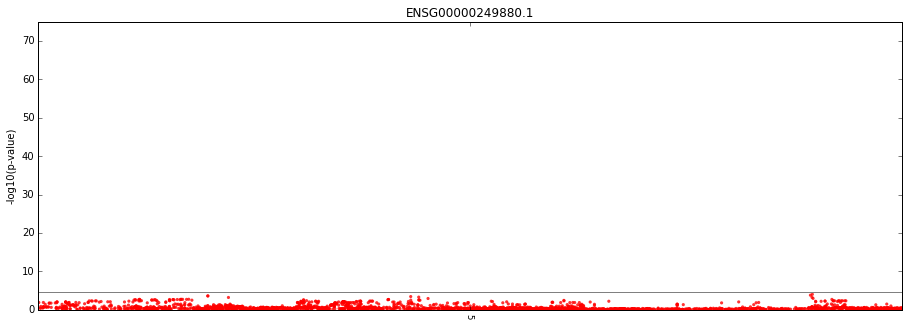

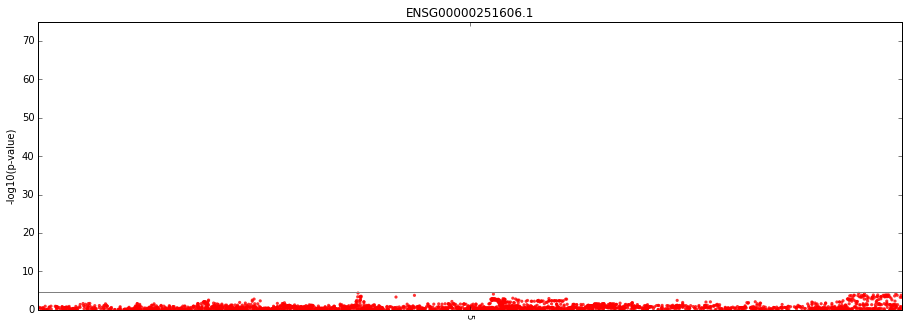

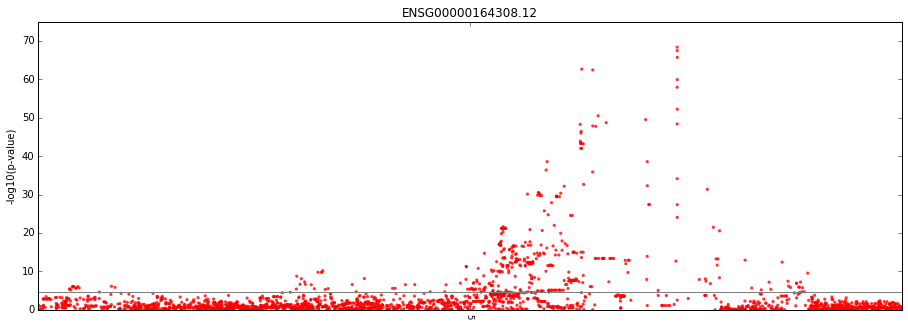

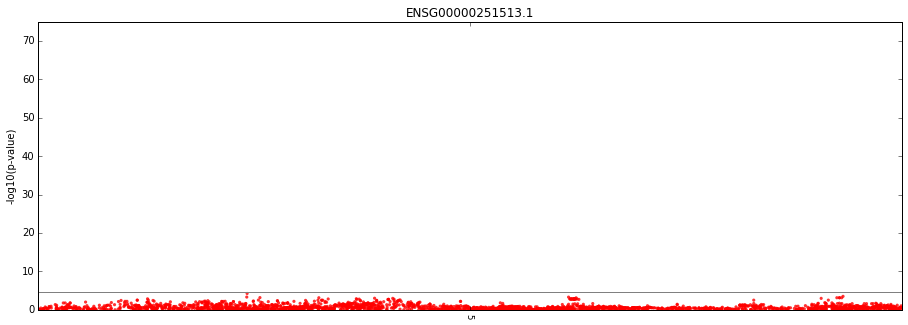

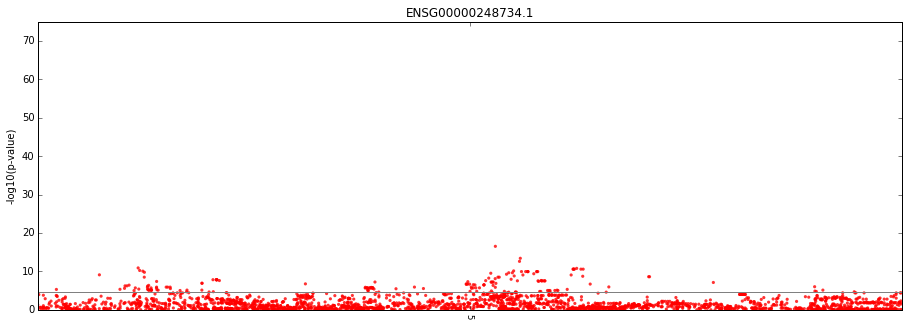

In [13]:
#Modified From: https://github.com/brentp/bio-playground/tree/master/plots
def _gen_data(vals, columns):
    for toks in vals:
        yield toks[columns[0]], int(toks[columns[1]]), float(toks[columns[2]])

def chr_cmp(a, b):
    a = a.lower().replace("_", ""); b = b.lower().replace("_", "")
    achr = a[3:] if a.startswith("chr") else a
    bchr = b[3:] if b.startswith("chr") else b

    try:
        return cmp(int(achr), int(bchr))
    except ValueError:
        if achr.isdigit() and not bchr.isdigit(): return -1
        if bchr.isdigit() and not achr.isdigit(): return 1
        # X Y
        return cmp(achr, bchr)


def chr_loc_cmp(alocs, blocs):
    return chr_cmp(alocs[0], blocs[0]) or cmp(alocs[1], blocs[1])

def manhattan(vals, columns, image_path, no_log, colors, title, lines, ymax):
    xs = []
    ys = []
    cs = []
    colors = cycle(colors)
    xs_by_chr = {}

    last_x = 0
    data = sorted(_gen_data(vals, columns), cmp=chr_loc_cmp)
    
    for seqid, rlist in groupby(data, key=itemgetter(0)):
        color = colors.next()
        rlist = list(rlist)
        region_xs = [last_x + r[1] for r in rlist]
        xs.extend(region_xs)
        ys.extend([r[2] for r in rlist])
        cs.extend([color] * len(rlist))

        xs_by_chr[seqid] = (region_xs[0] + region_xs[-1]) / 2

        # keep track so that chrs don't overlap.
        last_x = xs[-1]

    xs_by_chr = [(k, xs_by_chr[k]) for k in sorted(xs_by_chr.keys(), cmp=chr_cmp)]

    xs = np.array(xs)
    ys = np.array(ys) if no_log else -np.log10(ys)

    plt.close()
    f = plt.figure()
    #ax = f.add_axes((0.1, 0.09, 0.88, 0.85))
    ax=f.add_axes((1,1,2,1))
    if title is not None:
        plt.title(title)

    ax.set_ylabel('-log10(p-value)')
    if lines:
        ax.vlines(xs, 0, ys, colors=cs, alpha=0.5)
    else:
        ax.scatter(xs, ys, s=10, c=cs, alpha=0.8, edgecolors='none')

    # plot 0.05 line after multiple testing.
    ax.axhline(y=-np.log10(0.05 / len(data)), color='0.5', linewidth=1)
    plt.axis('tight')
    plt.xlim(xs[0], xs[-1])
    plt.ylim(ymin=0)
    if ymax is not None: plt.ylim(ymax=ymax)
    plt.xticks([c[1] for c in xs_by_chr], [c[0] for c in xs_by_chr], rotation=-90, size=8.5)
    #print >>sys.stderr, "saving to: %s" % image_path
    #plt.savefig(image_path)
    plt.show()
    
#main code
for key in data:
    manhattan(data[key], [0,1,2], 0, False, 'rgbk', key, False, 75)
    